In [1]:
# === STEP 0: Complete Environment Setup for Defect Prediction ===

# Install all required libraries
!pip install --quiet \
    pandas numpy matplotlib seaborn scikit-learn imbalanced-learn \
    xgboost lightgbm catboost arff tqdm joblib

# Import common data handling libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from tqdm import tqdm
import joblib
import warnings
warnings.filterwarnings("ignore")

# Import sklearn tools
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, RFE
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score, accuracy_score,
    matthews_corrcoef, log_loss, confusion_matrix, classification_report,
    average_precision_score
)

# Import models
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE

# Display setup confirmation
print("✅ All libraries installed and imported successfully.")
print("Ready for dataset loading and analysis.")


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 119.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 800.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.8/296.8 MB 1.2 MB/s eta 0:00:00
✅ All libraries installed and imported successfully.
Ready for dataset loading and analysis.


=== Loaded ANT dataset ===
Shape: (745, 21)
Columns: ['wmc', 'dit', 'noc', 'cbo', 'rfc', 'lcom', 'ca', 'ce', 'npm', 'lcom3', 'loc', 'dam', 'moa', 'mfa', 'cam', 'ic', 'cbm', 'amc', 'max_cc', 'avg_cc', 'bug']

Target column: bug

Label distribution:
bug
0.0    579
1.0    166
Name: count, dtype: int64

=== Summary Statistics ===
       count       mean         std  min        25%        50%   75%     max
wmc    745.0  11.071141   11.975963  0.0   4.000000   7.000000  14.0   120.0
dit    745.0   2.522148    1.398869  1.0   1.000000   2.000000   4.0     7.0
noc    745.0   0.731544    4.800357  0.0   0.000000   0.000000   0.0   102.0
cbo    745.0  11.046980   26.343149  0.0   4.000000   6.000000  11.0   499.0
rfc    745.0  34.362416   36.024972  0.0  11.000000  23.000000  43.0   288.0
lcom   745.0  89.147651  349.937555  0.0   0.000000   6.000000  53.0  6692.0
ca     745.0   5.655034   25.814223  0.0   0.000000   1.000000   4.0   498.0
ce     745.0   5.746309    5.653176  0.0   2.000000   4.

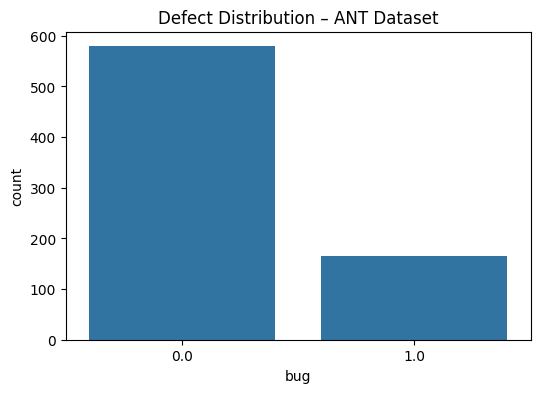

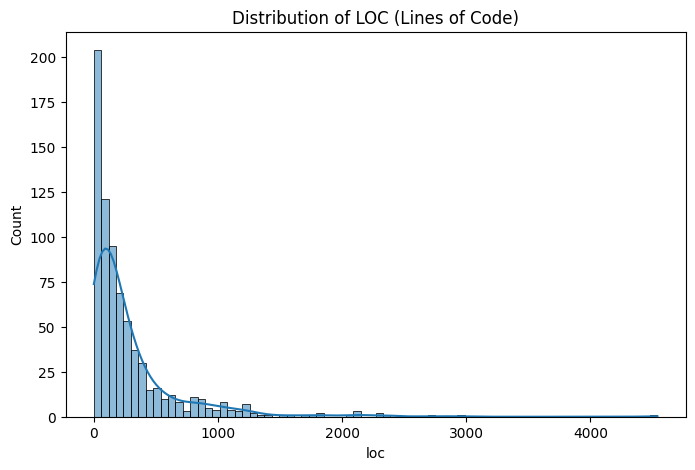

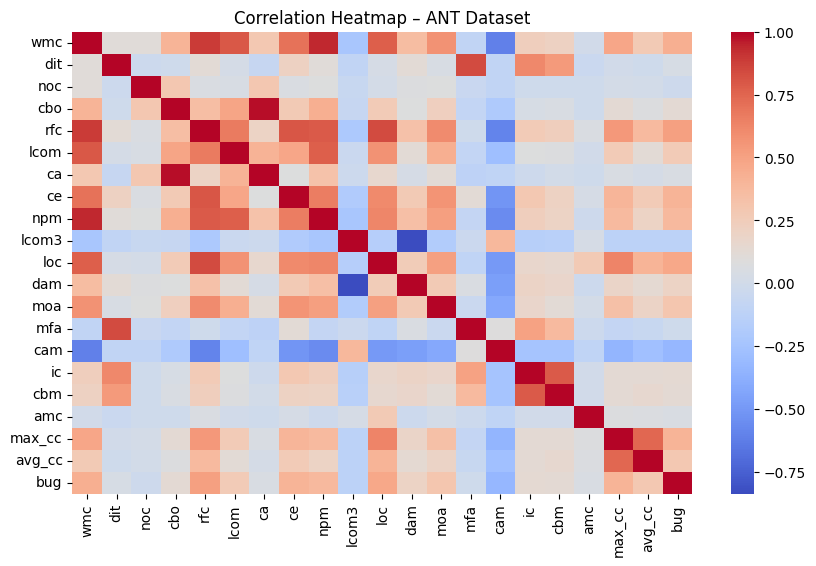

In [2]:
# === STEP 1: Load and Explore ANT Dataset (CSV) ===

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df_ant = pd.read_csv('/content/ant-1.7.csv')

print("=== Loaded ANT dataset ===")
print(f"Shape: {df_ant.shape}")
print(f"Columns: {list(df_ant.columns)}\n")

# --- Identify target column ---
possible_labels = ['bug', 'defects', 'Defective', 'target', 'label']
target_col = next((col for col in df_ant.columns if col.lower() in possible_labels), None)

if not target_col:
    raise ValueError("No target column found. Please ensure one column (e.g., 'bug') represents defect labels.")

print(f"Target column: {target_col}")

# --- Clean label column ---
df_ant[target_col] = df_ant[target_col].replace({
    'Y': 1, 'N': 0,
    'yes': 1, 'no': 0,
    'true': 1, 'false': 0
})
df_ant[target_col] = df_ant[target_col].astype(float)

# --- Basic info ---
print("\nLabel distribution:")
print(df_ant[target_col].value_counts())

# --- Summary Statistics ---
print("\n=== Summary Statistics ===")
print(df_ant.describe().T.head(10))

# --- Missing values ---
missing = df_ant.isnull().sum()
print("\nMissing values:")
print(missing[missing > 0] if missing.sum() > 0 else "0")

# --- Basic EDA ---
plt.figure(figsize=(6,4))
sns.countplot(x=target_col, data=df_ant)
plt.title("Defect Distribution – ANT Dataset")
plt.show()

plt.figure(figsize=(8,5))
if 'loc' in df_ant.columns:
    sns.histplot(df_ant['loc'], kde=True)
    plt.title("Distribution of LOC (Lines of Code)")
    plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(df_ant.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap – ANT Dataset")
plt.show()


Original shape: (745, 20), Class distribution: [579 166]
After variance threshold: (745, 20)
Dropping highly correlated features: ['ca', 'npm']
After correlation filter: (745, 18)

Top 10 features by mutual information:
 loc       0.141953
rfc       0.124954
lcom      0.095586
lcom3     0.088440
amc       0.085126
wmc       0.081414
cam       0.081354
ce        0.076550
max_cc    0.053234
moa       0.048457
dtype: float64

Selected features via RFE: ['wmc', 'cbo', 'rfc', 'lcom', 'lcom3', 'loc', 'cam', 'amc', 'max_cc', 'avg_cc']

Before SMOTE class distribution: [579 166]
After SMOTE class distribution: [579 579]
Resampled shape: (1158, 10)


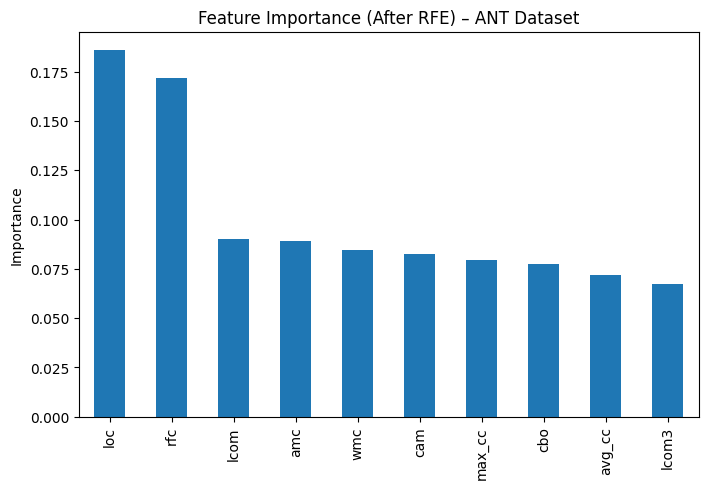


=== Step 2 Completed ===
You can now use X_res, y_res for model training (Step 3).


In [3]:
# === STEP 2: Feature Selection + SMOTE Balancing ===

from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

X = df_ant.drop(columns=['bug'])
y = df_ant['bug']

print(f"Original shape: {X.shape}, Class distribution: {np.bincount(y.astype(int))}")

# --- Variance Threshold ---
vt = VarianceThreshold(threshold=0.0)
X_vt = vt.fit_transform(X)
X_vt = pd.DataFrame(X_vt, columns=X.columns[vt.get_support()])
print(f"After variance threshold: {X_vt.shape}")

# --- Drop Highly Correlated Features ---
corr_matrix = X_vt.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
X_corr = X_vt.drop(columns=to_drop)
print(f"Dropping highly correlated features: {to_drop}")
print(f"After correlation filter: {X_corr.shape}")

# --- Mutual Information ---
mi = mutual_info_classif(X_corr, y)
mi_series = pd.Series(mi, index=X_corr.columns).sort_values(ascending=False)
print("\nTop 10 features by mutual information:\n", mi_series.head(10))

# --- Recursive Feature Elimination (RFE) ---
rf = RandomForestClassifier(random_state=42)
rfe = RFE(rf, n_features_to_select=10)
rfe.fit(X_corr, y)
selected_features = X_corr.columns[rfe.support_]
print("\nSelected features via RFE:", list(selected_features))

# --- SMOTE for class balancing ---
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_corr[selected_features], y)
print(f"\nBefore SMOTE class distribution: {np.bincount(y.astype(int))}")
print(f"After SMOTE class distribution: {np.bincount(y_res.astype(int))}")
print(f"Resampled shape: {X_res.shape}")

# --- Feature Importance Visualization ---
rf.fit(X_res, y_res)
importances = pd.Series(rf.feature_importances_, index=selected_features).sort_values(ascending=False)

plt.figure(figsize=(8,5))
importances.plot(kind='bar')
plt.title("Feature Importance (After RFE) – ANT Dataset")
plt.ylabel("Importance")
plt.show()

print("\n=== Step 2 Completed ===")
print("You can now use X_res, y_res for model training (Step 3).")


Train shape: (926, 10), Test shape: (232, 10)
RF best: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200} CV AUC: 0.9223268806322849
ET best: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200} CV AUC: 0.9350318826544214
XGB done
[LightGBM] [Info] Number of positive: 463, number of negative: 463
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 926, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LGB done
Stacking trained

--- RandomForest_Tuned ---
AUC: 0.9278  PR-AUC: 0.9049  F1: 0.8770  Precision: 0.8359  Recall: 0.9224  MCC: 0.7454  Acc: 0.8707  LogLoss: 0.3468
Confusion matrix:
 [[ 95  21]
 [  9 107]]
Classification report:
               precision    recall  f1-score   support

         0.0     

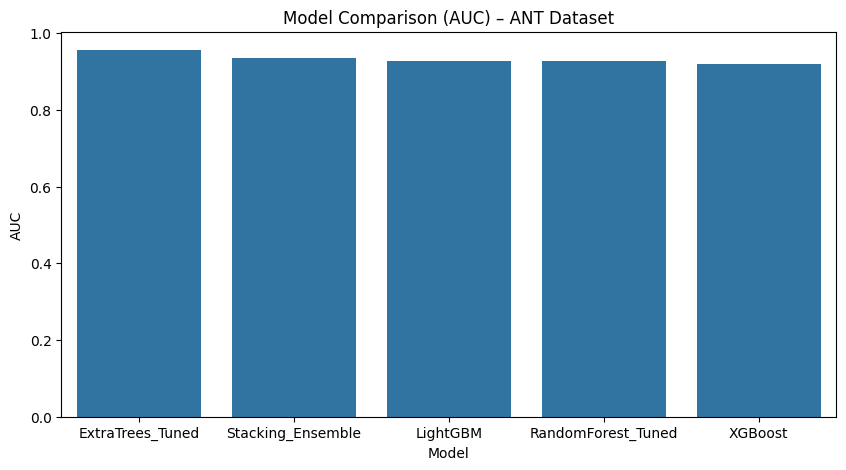


Saved model performances comparison table:
                Model       AUC    PR-AUC        F1  Precision    Recall  \
1    ExtraTrees_Tuned  0.956451  0.949374  0.903226   0.848485  0.965517   
4   Stacking_Ensemble  0.936534  0.904604  0.885246   0.843750  0.931034   
3            LightGBM  0.928508  0.907442  0.865306   0.821705  0.913793   
0  RandomForest_Tuned  0.927839  0.904862  0.877049   0.835938  0.922414   
2             XGBoost  0.920927  0.890711  0.866397   0.816794  0.922414   

        MCC  Accuracy   LogLoss  
1  0.800757  0.896552  0.298622  
4  0.762713  0.879310  0.310870  
3  0.720053  0.857759  0.393006  
0  0.745378  0.870690  0.346848  
2  0.721575  0.857759  0.358160  


In [4]:
# === STEP 3: Ensemble Model Training and Evaluation ===

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score, accuracy_score,
    matthews_corrcoef, log_loss, average_precision_score, confusion_matrix, classification_report
)
import pandas as pd
import matplotlib.pyplot as plt

# --- Split into Train/Test ---
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# --- Random Forest (Tuned) ---
rf = RandomForestClassifier(random_state=42)
rf_params = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5]}
rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring='roc_auc', n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_
print("RF best:", rf_grid.best_params_, "CV AUC:", rf_grid.best_score_)

# --- Extra Trees (Tuned) ---
et = ExtraTreesClassifier(random_state=42)
et_params = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5]}
et_grid = GridSearchCV(et, et_params, cv=3, scoring='roc_auc', n_jobs=-1)
et_grid.fit(X_train, y_train)
et_best = et_grid.best_estimator_
print("ET best:", et_grid.best_params_, "CV AUC:", et_grid.best_score_)

# --- XGBoost ---
xgb = XGBClassifier(
    eval_metric='logloss', use_label_encoder=False, random_state=42, n_estimators=200,
    learning_rate=0.05, max_depth=6, subsample=0.8, colsample_bytree=0.8
)
xgb.fit(X_train, y_train)
print("XGB done")

# --- LightGBM ---
lgb = LGBMClassifier(random_state=42, n_estimators=200, learning_rate=0.05)
lgb.fit(X_train, y_train)
print("LGB done")

# --- Stacking Ensemble ---
stack = StackingClassifier(
    estimators=[
        ('rf', rf_best),
        ('et', et_best),
        ('xgb', xgb),
        ('lgb', lgb)
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    passthrough=True,
    n_jobs=-1
)
stack.fit(X_train, y_train)
print("Stacking trained")

# --- Evaluation Function ---
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    metrics = {
        "Model": name,
        "AUC": roc_auc_score(y_test, y_proba),
        "PR-AUC": average_precision_score(y_test, y_proba),
        "F1": f1_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "MCC": matthews_corrcoef(y_test, y_pred),
        "Accuracy": accuracy_score(y_test, y_pred),
        "LogLoss": log_loss(y_test, y_proba)
    }
    print(f"\n--- {name} ---")
    print(f"AUC: {metrics['AUC']:.4f}  PR-AUC: {metrics['PR-AUC']:.4f}  F1: {metrics['F1']:.4f}  "
          f"Precision: {metrics['Precision']:.4f}  Recall: {metrics['Recall']:.4f}  MCC: {metrics['MCC']:.4f}  "
          f"Acc: {metrics['Accuracy']:.4f}  LogLoss: {metrics['LogLoss']:.4f}")
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification report:\n", classification_report(y_test, y_pred))
    return metrics

# --- Evaluate all models ---
results = []
for name, model in [
    ("RandomForest_Tuned", rf_best),
    ("ExtraTrees_Tuned", et_best),
    ("XGBoost", xgb),
    ("LightGBM", lgb),
    ("Stacking_Ensemble", stack)
]:
    results.append(evaluate_model(name, model, X_test, y_test))

# --- Comparison Plot ---
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by="AUC", ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x='Model', y='AUC', data=df_results)
plt.title("Model Comparison (AUC) – ANT Dataset")
plt.show()

print("\nSaved model performances comparison table:")
print(df_results)


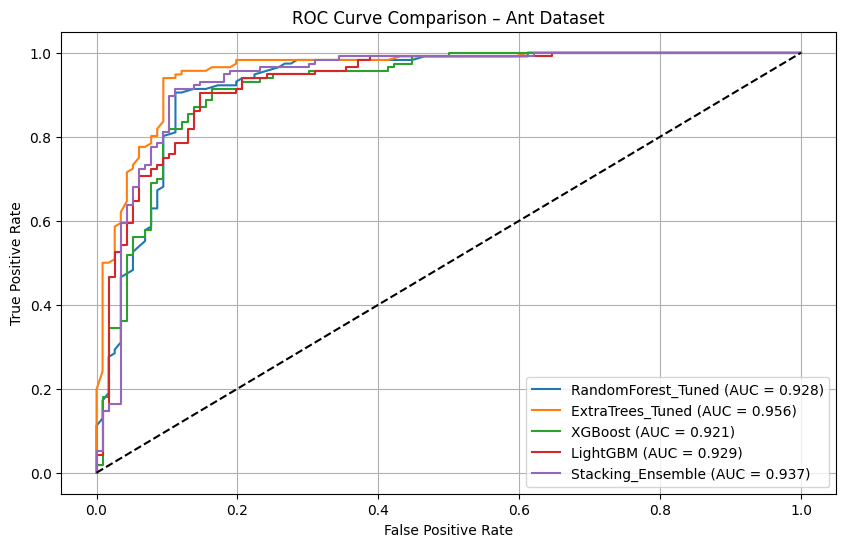

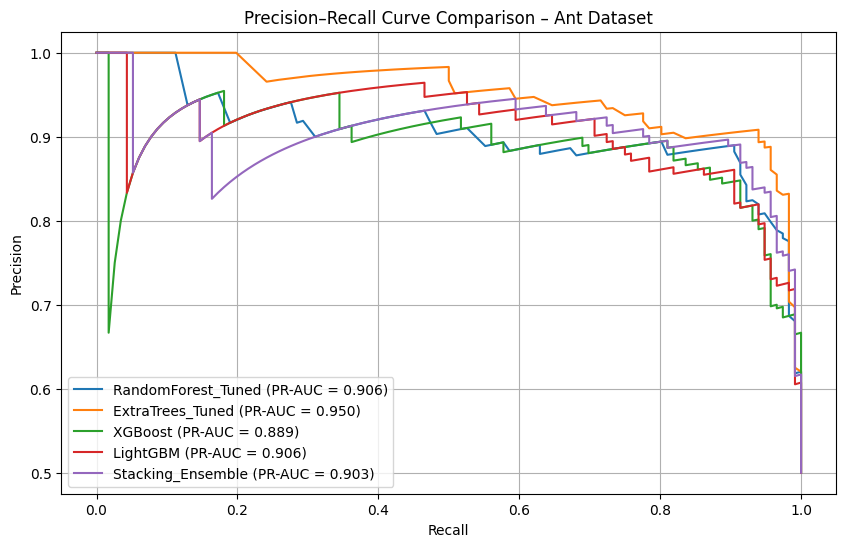

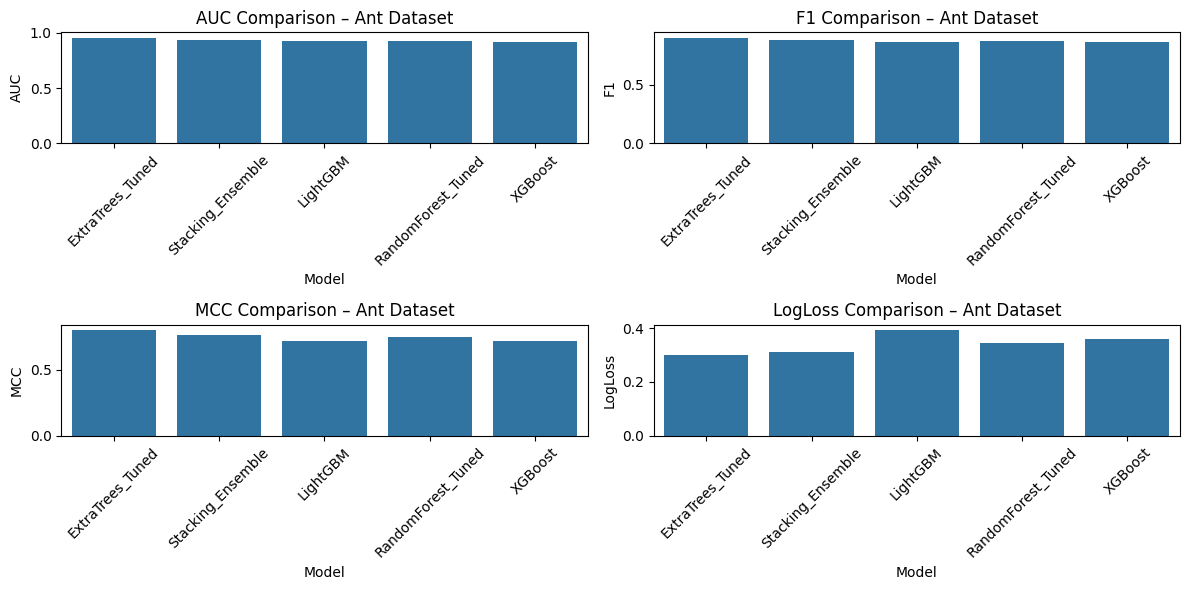

In [5]:
# === STEP 4: ROC and Precision-Recall Curves ===

from sklearn.metrics import roc_curve, precision_recall_curve, auc

models = {
    "RandomForest_Tuned": rf_best,
    "ExtraTrees_Tuned": et_best,
    "XGBoost": xgb,
    "LightGBM": lgb,
    "Stacking_Ensemble": stack
}

plt.figure(figsize=(10, 6))
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison – Ant Dataset")
plt.legend()
plt.grid(True)
plt.show()


# === Precision-Recall Curve ===
plt.figure(figsize=(10, 6))
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{name} (PR-AUC = {pr_auc:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve Comparison – Ant Dataset")
plt.legend()
plt.grid(True)
plt.show()


# === Metric Comparison (AUC, F1, MCC, LogLoss) ===
metrics_to_plot = ["AUC", "F1", "MCC", "LogLoss"]
plt.figure(figsize=(12, 6))
for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.barplot(x="Model", y=metric, data=df_results)
    plt.xticks(rotation=45)
    plt.title(metric + " Comparison – Ant Dataset")
    plt.tight_layout()
plt.show()


Loaded model: RandomForest_Tuned
Loaded model: ExtraTrees_Tuned
Loaded model: XGBoost
Loaded model: LightGBM
Loaded model: Stacking_Ensemble

=== Evaluating on ant-1.3 (shape (125, 21)) ===
  RandomForest_Tuned: AUC=0.7574, F1=0.4828, LogLoss=0.5648
  ExtraTrees_Tuned: AUC=0.7881, F1=0.4667, LogLoss=0.5260
  XGBoost: AUC=0.7367, F1=0.4561, LogLoss=0.6417
  LightGBM: AUC=0.7319, F1=0.4151, LogLoss=0.7945
  Stacking_Ensemble: AUC=0.7576, F1=0.4074, LogLoss=0.5763

=== Evaluating on ant-1.4 (shape (178, 21)) ===
  RandomForest_Tuned: AUC=0.5588, F1=0.3232, LogLoss=1.5110
  ExtraTrees_Tuned: AUC=0.5667, F1=0.3168, LogLoss=1.8630
  XGBoost: AUC=0.5791, F1=0.2979, LogLoss=0.9145
  LightGBM: AUC=0.6137, F1=0.3146, LogLoss=1.1225
  Stacking_Ensemble: AUC=0.5805, F1=0.3146, LogLoss=0.8379

=== Evaluating on ant-1.5 (shape (293, 21)) ===
  RandomForest_Tuned: AUC=0.7741, F1=0.3929, LogLoss=0.4976
  ExtraTrees_Tuned: AUC=0.7737, F1=0.4107, LogLoss=0.7206
  XGBoost: AUC=0.7462, F1=0.3774, LogLoss=

,Dataset,Model,AUC,PR-AUC,F1,Precision,Recall,MCC,Accuracy,LogLoss
1,ant-1.3,ExtraTrees_Tuned,0.788095,0.349895,0.466667,0.350000,0.700000,0.355529,0.744000,0.526014
4,ant-1.3,Stacking_Ensemble,0.757619,0.345564,0.407407,0.323529,0.550000,0.272656,0.744000,0.576264
0,ant-1.3,RandomForest_Tuned,0.757381,0.351746,0.482759,0.368421,0.700000,0.375728,0.760000,0.564773
2,ant-1.3,XGBoost,0.736667,0.361825,0.456140,0.351351,0.650000,0.338448,0.752000,0.641668
3,ant-1.3,LightGBM,0.731905,0.375812,0.415094,0.333333,0.550000,0.283169,0.752000,0.794535
8,ant-1.4,LightGBM,0.613678,0.308786,0.314607,0.285714,0.350000,0.090064,0.657303,1.122466
9,ant-1.4,Stacking_Ensemble,0.580525,0.266795,0.314607,0.285714,0.350000,0.090064,0.657303,0.837863
7,ant-1.4,XGBoost,0.579076,0.289026,0.297872,0.259259,0.350000,0.054609,0.629213,0.914522
6,ant-1.4,ExtraTrees_Tuned,0.566667,0.255118,0.316832,0.262295,0.400000,0.065003,0.612360,1.862974
5,ant-1.4,RandomForest_Tuned,0.558786,0.299161,0.323232,0.271186,0.400000,0.078388,0.623596,1.511034


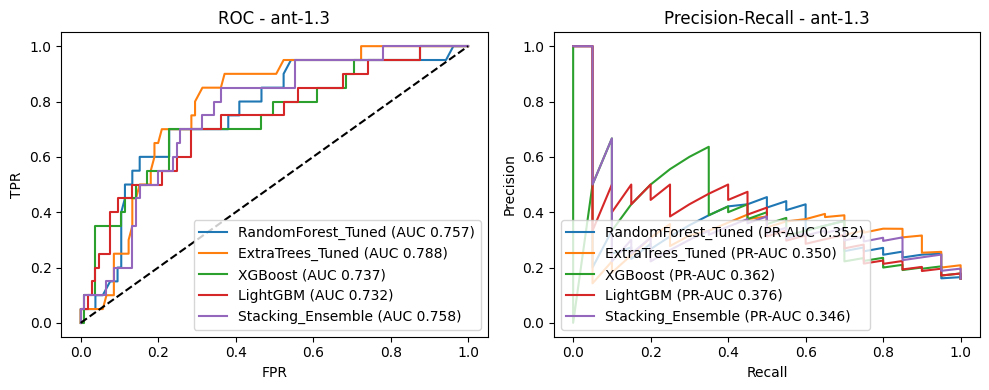

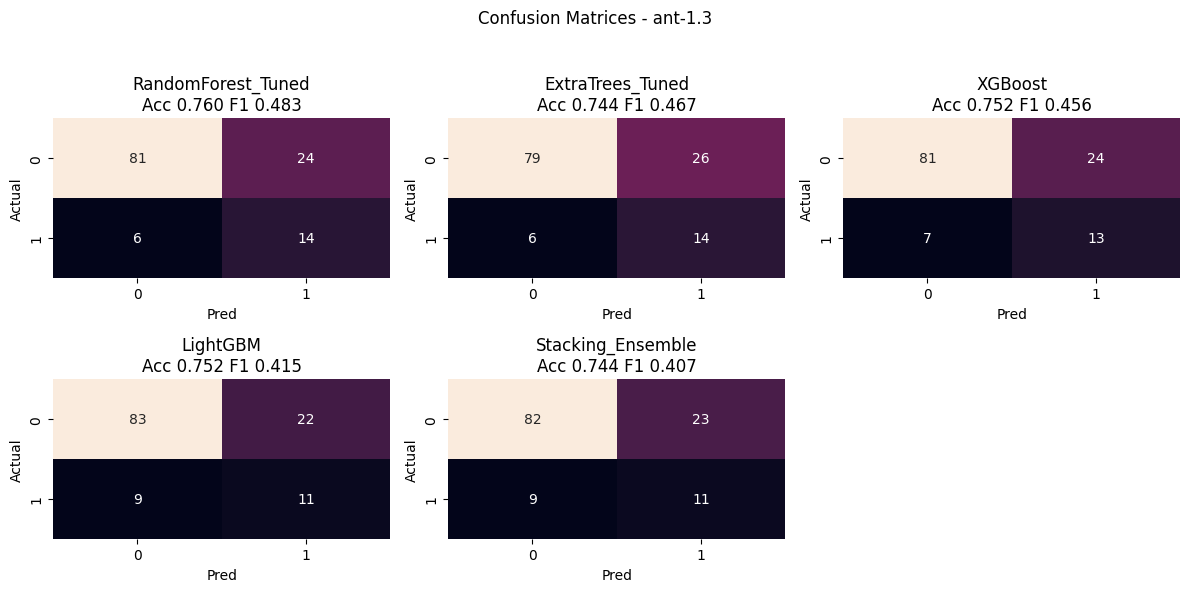

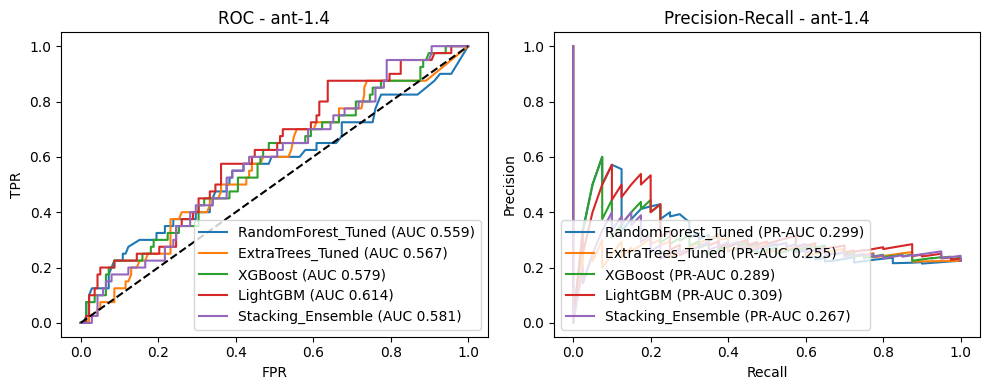

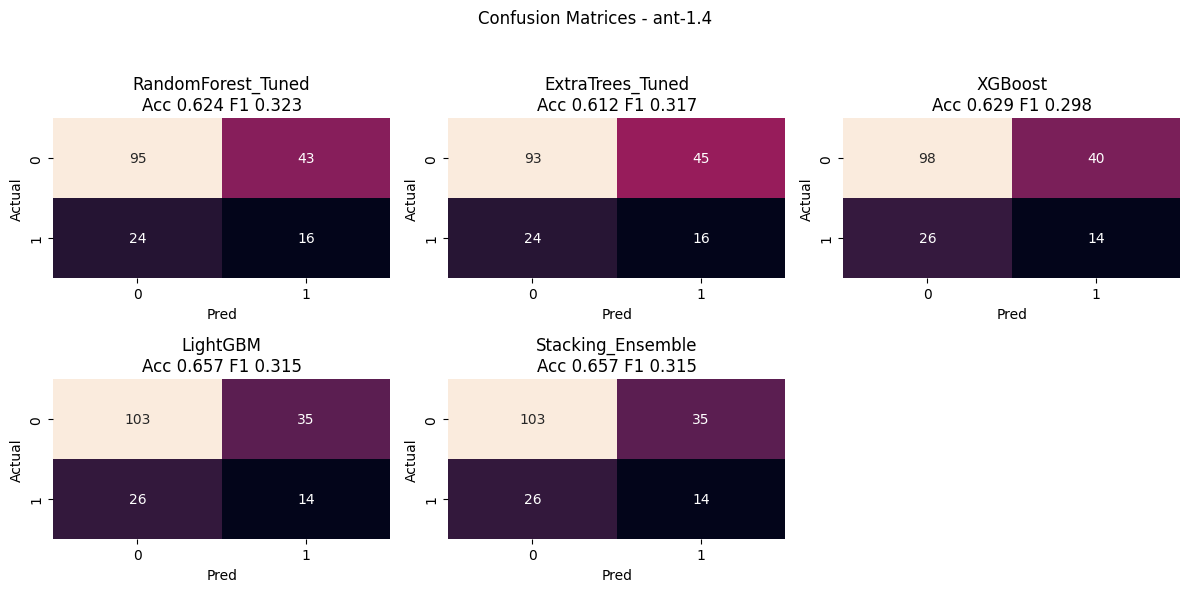

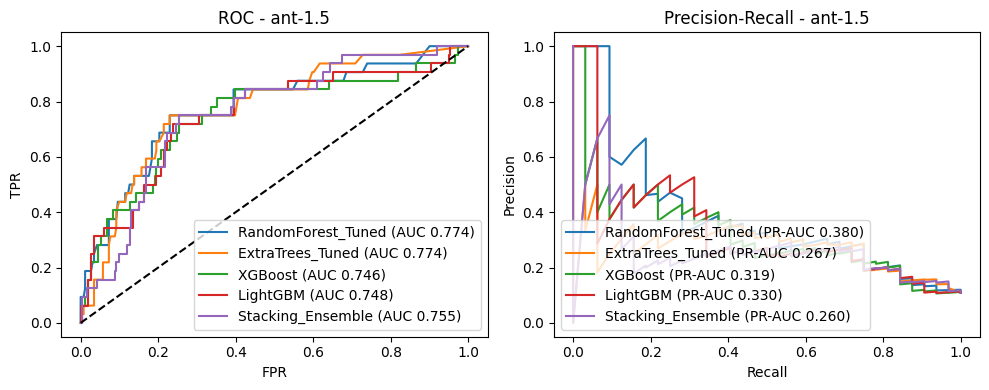

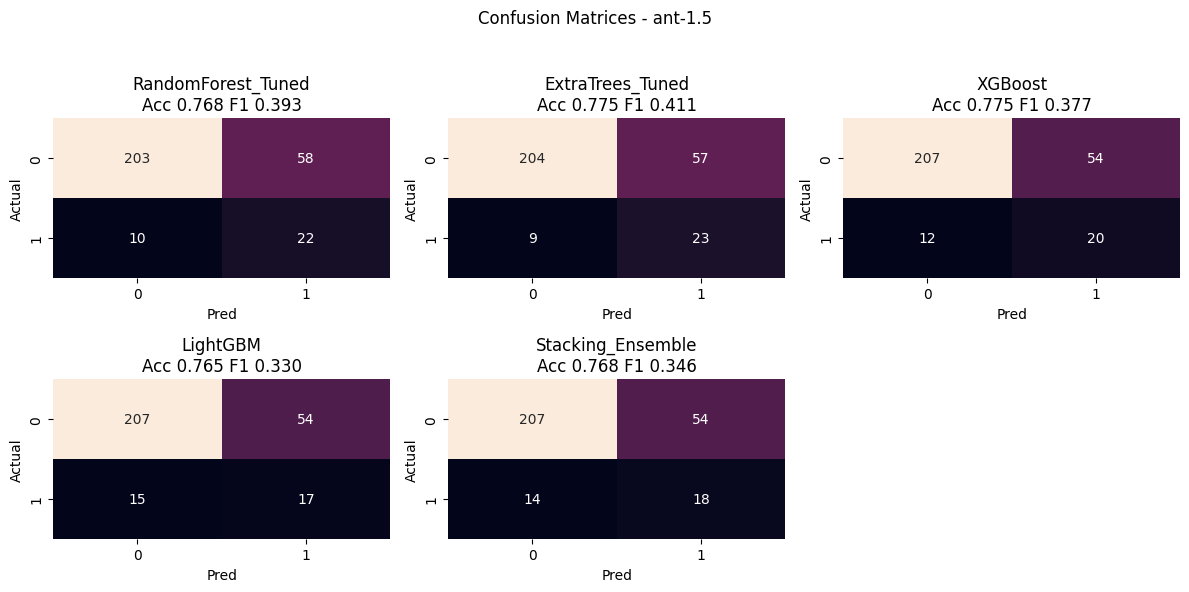

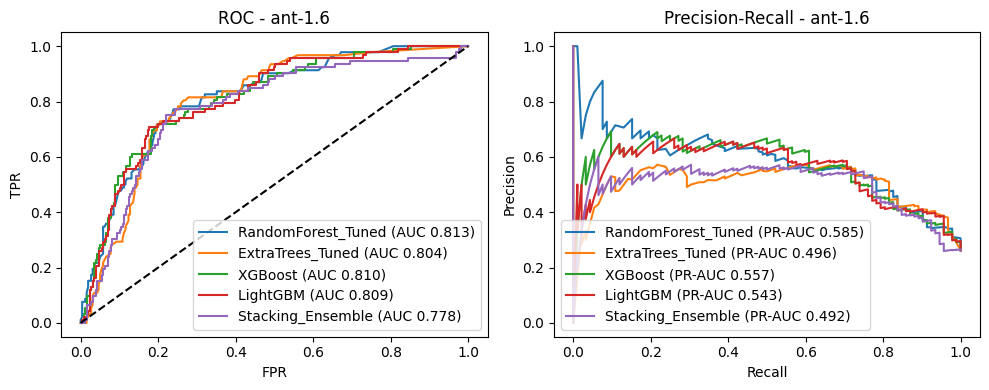

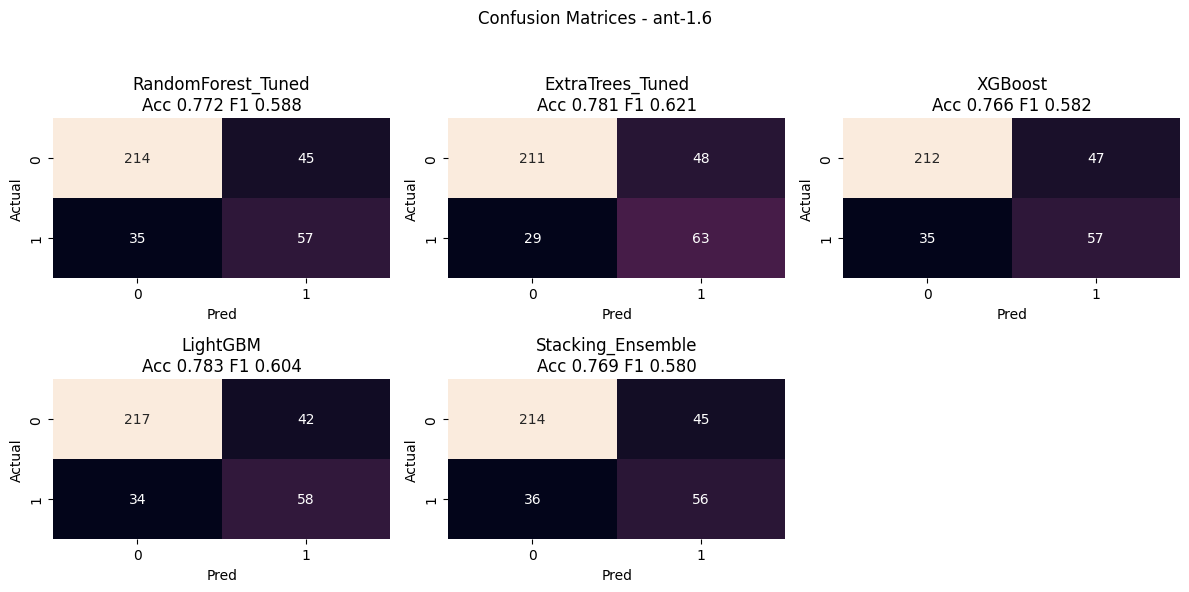

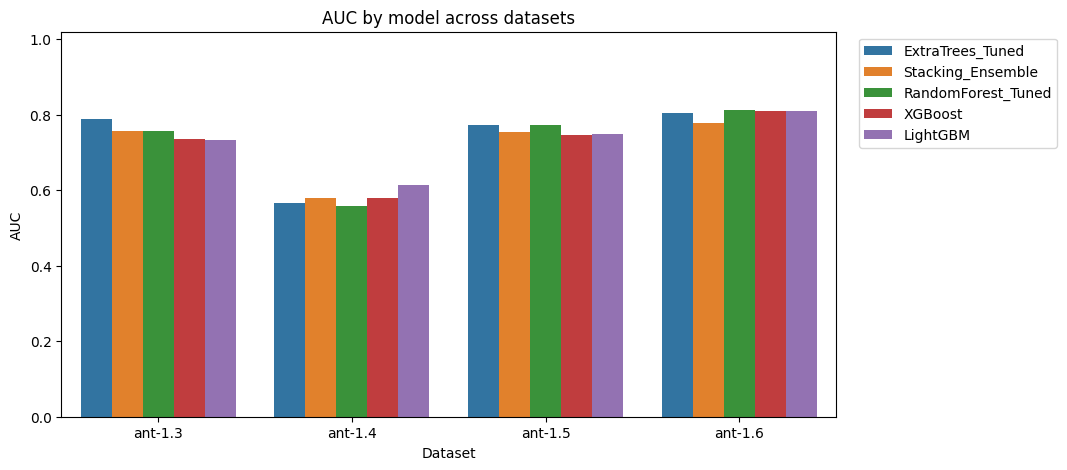

Saved summary to ant_cross_eval_summary.csv


In [6]:
# Cross-eval: Ant 1.7 models -> Ant 1.3 / 1.4 / 1.5 / 1.6
import os
import glob
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, log_loss, classification_report
)

# -------- Configuration --------
models_expected = {
    "RandomForest_Tuned": ["rf_best", "rf_best.pkl", "random_forest.pkl"],
    "ExtraTrees_Tuned" : ["et_best", "et_best.pkl", "extra_trees.pkl"],
    "XGBoost" : ["xgb", "xgb.pkl", "xgboost.pkl"],
    "LightGBM": ["lgb", "lgb.pkl", "lightgbm.pkl"],
    "Stacking_Ensemble": ["stack", "stacking_model.pkl", "stack_clf.pkl"]
}

# features used for Ant models (from your previous step)
ant_features = ['wmc','cbo','rfc','lcom','lcom3','loc','cam','amc','max_cc','avg_cc']

# dataset paths (change directory if needed)
dataset_files = {
    "ant-1.3": "/content/ant-1.3.csv",
    "ant-1.4": "/content/ant-1.4.csv",
    "ant-1.5": "/content/ant-1.5.csv",
    "ant-1.6": "/content/ant-1.6.csv"
}

# -------- helper: load model (try globals then files) --------
def load_model_by_keys(keys):
    # try to find model in globals
    g = globals()
    for k in keys:
        if k in g:
            return g[k]
    # try to load common filenames relative to working dir
    for k in keys:
        if os.path.exists(k):
            return joblib.load(k)
        if os.path.exists(k + ".pkl"):
            return joblib.load(k + ".pkl")
        if os.path.exists(k + ".joblib"):
            return joblib.load(k + ".joblib")
    # try fuzzy search in cwd
    for pat in ["*.pkl","*.joblib"]:
        for fname in glob.glob(pat):
            name_lower = os.path.basename(fname).lower()
            for key in keys:
                if key.lower() in name_lower:
                    return joblib.load(fname)
    raise FileNotFoundError(f"Model not found for keys: {keys}")

# -------- load available models --------
loaded_models = {}
for model_name, keys in models_expected.items():
    try:
        mdl = load_model_by_keys(keys)
        loaded_models[model_name] = mdl
        print(f"Loaded model: {model_name}")
    except Exception as e:
        print(f"WARNING: {model_name} not found ({e}). Skipping.")

if not loaded_models:
    raise RuntimeError("No models available. Make sure rf_best / et_best / xgb / lgb / stack exist in globals or disk.")

# -------- evaluation function --------
def evaluate_model_on_df(model, df, features, target_col='bug'):
    # prepare X, y
    if target_col not in df.columns:
        # try common target names
        for cand in ['bug','defects','Defective','defective','label','class','buggy']:
            if cand in df.columns:
                target_col = cand
                break
    y = df[target_col].astype(float).fillna(0).astype(int)
    # build X aligning features (fill missing with 0)
    X = pd.DataFrame(index=df.index)
    for f in features:
        X[f] = df[f] if f in df.columns else 0.0
    X = X[features]
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0.0)
    # predictions
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X)[:,1]
    else:
        # fallback: use decision_function then sigmoid
        if hasattr(model, "decision_function"):
            df_scores = model.decision_function(X)
            # simple sigmoid
            y_proba = 1/(1+np.exp(-df_scores))
        else:
            y_proba = model.predict(X)  # not ideal; will be treated as labels
            # ensure between 0 and 1
            y_proba = np.clip(y_proba, 0, 1)

    y_pred = (y_proba >= 0.5).astype(int)

    # metrics
    fpr, tpr, _ = roc_curve(y, y_proba)
    prec, rec, _ = precision_recall_curve(y, y_proba)
    metrics = {
        'AUC': auc(fpr, tpr),
        'PR-AUC': auc(rec, prec),
        'Accuracy': accuracy_score(y, y_pred),
        'Precision': precision_score(y, y_pred, zero_division=0),
        'Recall': recall_score(y, y_pred, zero_division=0),
        'F1': f1_score(y, y_pred, zero_division=0),
        'MCC': matthews_corrcoef(y, y_pred),
        'LogLoss': log_loss(y, y_proba, labels=[0,1])
    }
    return metrics, (fpr, tpr), (rec, prec), confusion_matrix(y, y_pred), classification_report(y, y_pred, zero_division=0)

# -------- evaluate all models on each dataset and collect results --------
all_results = []

for ds_name, ds_path in dataset_files.items():
    if not os.path.exists(ds_path):
        print(f"Dataset file missing: {ds_path} — skipping {ds_name}")
        continue
    df = pd.read_csv(ds_path)
    print(f"\n=== Evaluating on {ds_name} (shape {df.shape}) ===")
    ds_results = []
    for mname, model in loaded_models.items():
        try:
            metrics, roc_pts, pr_pts, cm, crep = evaluate_model_on_df(model, df, ant_features, target_col='bug')
            print(f"  {mname}: AUC={metrics['AUC']:.4f}, F1={metrics['F1']:.4f}, LogLoss={metrics['LogLoss']:.4f}")
            entry = metrics.copy()
            entry.update({'Model': mname, 'Dataset': ds_name, 'ROC': roc_pts, 'PR': pr_pts, 'CM': cm, 'Report': crep})
            ds_results.append(entry)
        except Exception as e:
            print(f"  ERROR evaluating {mname} on {ds_name}: {e}")
    if ds_results:
        all_results.extend(ds_results)

# convert to DataFrame for tabular comparison
summary_rows = []
for r in all_results:
    summary_rows.append({
        'Dataset': r['Dataset'], 'Model': r['Model'],
        'AUC': r['AUC'], 'PR-AUC': r['PR-AUC'], 'F1': r['F1'],
        'Precision': r['Precision'], 'Recall': r['Recall'],
        'MCC': r['MCC'], 'Accuracy': r['Accuracy'], 'LogLoss': r['LogLoss']
    })
summary_df = pd.DataFrame(summary_rows).sort_values(['Dataset','AUC'], ascending=[True,False])
display(summary_df)

# -------- Plotting: per-dataset comparisons --------
for ds in summary_df['Dataset'].unique():
    sub = [r for r in all_results if r['Dataset']==ds]
    if not sub:
        continue
    plt.figure(figsize=(10,4))
    # ROC
    plt.subplot(1,2,1)
    for r in sub:
        fpr,tpr = r['ROC']
        plt.plot(fpr, tpr, label=f"{r['Model']} (AUC {r['AUC']:.3f})")
    plt.plot([0,1],[0,1],'k--')
    plt.title(f"ROC - {ds}")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(loc='lower right')
    # PR
    plt.subplot(1,2,2)
    for r in sub:
        rec, prec = r['PR']
        plt.plot(rec, prec, label=f"{r['Model']} (PR-AUC {r['PR-AUC']:.3f})")
    plt.title(f"Precision-Recall - {ds}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

    # Confusion matrices (grid)
    n = len(sub)
    cols = min(3, n)
    rows = (n+cols-1)//cols
    plt.figure(figsize=(4*cols,3*rows))
    for i, r in enumerate(sub,1):
        cm = r['CM']
        plt.subplot(rows, cols, i)
        sns.heatmap(cm, annot=True, fmt='d', cbar=False)
        plt.title(f"{r['Model']}\nAcc {r['Accuracy']:.3f} F1 {r['F1']:.3f}")
        plt.xlabel("Pred"); plt.ylabel("Actual")
    plt.suptitle(f"Confusion Matrices - {ds}")
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

# -------- Aggregated metric barplot (AUC per model per dataset) --------
plt.figure(figsize=(10,5))
sns.barplot(data=summary_df, x='Dataset', y='AUC', hue='Model')
plt.title("AUC by model across datasets")
plt.ylim(0,1.02)
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left')
plt.show()

# Save summary
summary_df.to_csv("ant_cross_eval_summary.csv", index=False)
print("Saved summary to ant_cross_eval_summary.csv")
